The goal of this project is to build image classification model based on door numbers from Street View images. We will first use KNN and then use Neural networks and compare the efficiency and accuracy of the traditional model and neural networks.

The model should be able to take an image from the SVHN database as identify the digit. This is a multi-class classification problem with 10 classes - 0-9 digits.



In [28]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import h5py
from sklearn.model_selection import train_test_split
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



In [29]:
dataFromFile = h5py.File('SVHN_single_grey1.h5', 'r')

X_train = dataFromFile['X_train']
X_train_original = dataFromFile['X_train']
X_test = dataFromFile['X_test']
y_test = dataFromFile['y_test']
y_train = dataFromFile['y_train']
    
X_train = X_train[:].reshape(-1, 1024) /255
X_test = X_test[:].reshape(-1, 1024) /255


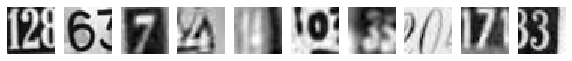

label for each of the above image: [2 6 7 4 4 0 3 0 7 3]


In [30]:
# visualizing the first 10 images in the dataset and their labels
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train_original[i], cmap="gray")
    plt.axis('off')
plt.show()
print('label for each of the above image: %s' % (y_train[0:10]))

We will now consider a subset of the data for KNN classification. K Nearest neighbours classification is a traditional ML model building. We will analyze it is pertinence in the context of OCR.

In [31]:
X_train_sub = X_train[:3000]
y_train_sub = y_train[:3000]
X_test_sub = X_test[:1000]
y_test_sub = y_test[:1000]

In [32]:
for k in range(1,30):
    knnClassifier = KNeighborsClassifier(n_neighbors=k, weights = 'uniform', metric='euclidean')
    knnClassifier.fit(X_train_sub, y_train_sub)

    score = knnClassifier.score(X_test_sub, y_test_sub)
    print(f"When k={k} score is {score*100}")


When k=1 score is 32.1
When k=2 score is 30.7
When k=3 score is 30.7
When k=4 score is 33.6
When k=5 score is 33.300000000000004
When k=6 score is 33.6
When k=7 score is 32.800000000000004
When k=8 score is 34.4
When k=9 score is 34.599999999999994
When k=10 score is 34.300000000000004
When k=11 score is 34.5
When k=12 score is 34.599999999999994
When k=13 score is 34.4
When k=14 score is 35.4
When k=15 score is 34.699999999999996
When k=16 score is 35.8
When k=17 score is 35.4
When k=18 score is 35.5
When k=19 score is 35.0
When k=20 score is 34.8
When k=21 score is 34.8
When k=22 score is 34.0
When k=23 score is 33.300000000000004
When k=24 score is 34.1
When k=25 score is 33.5
When k=26 score is 33.2
When k=27 score is 33.6
When k=28 score is 33.2
When k=29 score is 33.2


The accuracy seems to be the best at 35.8% for k value 16. Let's set the k value to 16 and train a model with the entire training dataset.

In [33]:
knnClassifier = KNeighborsClassifier(n_neighbors=16)
knnClassifier.fit(X_train, y_train)

predictions_knn = knnClassifier.predict(X_test)


In [34]:
print("EVALUATION ON TESTING DATA")
print(classification_report(y_test, predictions_knn))

print ("Confusion matrix")
print(confusion_matrix(y_test,predictions_knn))


EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

           0       0.44      0.69      0.54      1814
           1       0.47      0.73      0.57      1828
           2       0.61      0.55      0.58      1803
           3       0.45      0.43      0.44      1719
           4       0.66      0.65      0.65      1812
           5       0.51      0.39      0.44      1768
           6       0.49      0.41      0.44      1832
           7       0.71      0.62      0.66      1808
           8       0.46      0.36      0.40      1812
           9       0.56      0.42      0.48      1804

    accuracy                           0.53     18000
   macro avg       0.54      0.52      0.52     18000
weighted avg       0.54      0.53      0.52     18000

Confusion matrix
[[1254   69   35   39   53   46  103   35   81   99]
 [  97 1336   65   88   79   35   29   48   20   31]
 [ 101  230  987   98   46   34   37  141   52   77]
 [ 132  245  143  739   50  156   35  

As you can see above, using KNN has very low accuracy and the process with all 42000 images in the training data and 18000 images in test data took 30+ minutes. This is one of the obvious reasons the traditional classification models are not used for OCR. 

### Neural Network Model
We will now import the appropriate modules for developing a neural network model. We will add layers as needed and do BatchNormalization and droputs as needed to get the best accuracy. We will use ReLU as the activation function.



In [35]:
import tensorflow.keras
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,ReLU,Dense,BatchNormalization


The number of classes in the case of OCR of house numbers is 10, which includes all digits from 0-9. We will use `sparse_categorical_crossentropy` for losses, to treat the outcome as categorical values and not continuous. We will also use `'sparse_categorical_accuracy` for assessing the metrics of the model. Since the output of the model is categorical, we will use softmax activation function for the final layer and ReLU for the hidden layers to get better accuracy. 

In [88]:
model = Sequential()
model.add(BatchNormalization(input_shape=(1024,)))
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization(input_shape=(256,)))
model.add(Dense(64,activation='relu'))
model.add(Dropout(rate=0.2))
num_classes = len(np.unique(y_train))
model.add(Dense(num_classes,activation='softmax'))
adam = optimizers.Adam(lr=0.002)
model.compile(loss=losses.sparse_categorical_crossentropy, optimizer=adam, metrics=['sparse_categorical_accuracy'])
model.fit(X_train, y_train, batch_size=200, epochs=30,validation_data=(X_test, y_test),verbose=0)

_, train_data_accuracy = model.evaluate(X_train, y_train)
print('Accuracy: %.2f' % (train_data_accuracy*100))

_, test_data_accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (test_data_accuracy*100))

42000/42000 [==============================] - 4s 90us/sample - loss: 0.2503 - sparse_categorical_accuracy: 0.9219
Accuracy: 92.19
18000/18000 [==============================] - 1s 75us/sample - loss: 0.5037 - sparse_categorical_accuracy: 0.8601
Accuracy: 86.01


As observed above the accuracy of the model with the training data is 92.05% and the accuracy with test data is 85.07%. 

In [57]:
nnmodelPredictions = model.predict_classes(X_train)

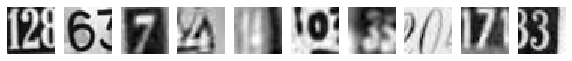

label for each of the above image: [2 6 7 4 4 0 3 0 7 3]
Model Prediction for each of the above image: [2 5 7 4 4 9 3 7 7 3]


In [63]:
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train_original[i], cmap="gray")
    plt.axis('off')
plt.show()
print('label for each of the above image: %s' % (y_train[0:10]))
print('Model Prediction for each of the above image: %s' % nnmodelPredictions[0:10])


We will fine tune some of the hyperparameters and develop another model to see if the performance can be improved. 

In [82]:
model2 = Sequential()
model2.add(BatchNormalization(input_shape=(1024,)))
model2.add(Dense(256,activation='relu'))
model2.add(BatchNormalization(input_shape=(256,)))
model2.add(Dense(128,activation='relu'))
model2.add(BatchNormalization(input_shape=(128,)))
model2.add(Dense(64,activation='relu'))
model2.add(Dropout(rate=0.2))
num_classes = len(np.unique(y_train))
model2.add(Dense(num_classes,activation='softmax'))
lrArr = [0.01,0.02,0.03,0.04,0.05]
momArr = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for lr in lrArr:
    for mom in momArr:
        sgd = optimizers.SGD(lr=lr, momentum=mom, nesterov=False)
        model2.compile(loss=losses.sparse_categorical_crossentropy, optimizer=sgd, metrics=['sparse_categorical_accuracy'])

        model2.fit(X_train, y_train, batch_size=200, epochs=30,validation_data=(X_test, y_test),verbose=0)
        print(f'lr {lr} and momentum {mom}')
        print("----------------------------------")
        _, train_data_accuracy = model2.evaluate(X_train, y_train)
        print('Accuracy Training Data: %.2f' % (train_data_accuracy*100))

        _, test_data_accuracy = model2.evaluate(X_test, y_test)
        print('Accuracy Test Data: %.2f \n\n' % (test_data_accuracy*100))

lr 0.01 and momentum 0.1
----------------------------------
42000/42000 [==============================] - 3s 67us/sample - loss: 0.3867 - sparse_categorical_accuracy: 0.8815
Accuracy Training Data: 88.15
18000/18000 [==============================] - 1s 68us/sample - loss: 0.6068 - sparse_categorical_accuracy: 0.8193
Accuracy Test Data: 81.93 


lr 0.01 and momentum 0.2
----------------------------------
42000/42000 [==============================] - 3s 66us/sample - loss: 0.2235 - sparse_categorical_accuracy: 0.9349
Accuracy Training Data: 93.49
18000/18000 [==============================] - 1s 69us/sample - loss: 0.5668 - sparse_categorical_accuracy: 0.8407
Accuracy Test Data: 84.07 


lr 0.01 and momentum 0.3
----------------------------------
42000/42000 [==============================] - 3s 72us/sample - loss: 0.1595 - sparse_categorical_accuracy: 0.95420s - loss: 0.1605 - sparse_categorical_accurac
Accuracy Training Data: 95.42
18000/18000 [==============================] - 1s 7

42000/42000 [==============================] - 3s 81us/sample - loss: 0.0045 - sparse_categorical_accuracy: 0.9992
Accuracy Training Data: 99.92
18000/18000 [==============================] - 2s 84us/sample - loss: 1.0277 - sparse_categorical_accuracy: 0.8539
Accuracy Test Data: 85.39 


lr 0.03 and momentum 0.7
----------------------------------
42000/42000 [==============================] - 4s 84us/sample - loss: 0.0074 - sparse_categorical_accuracy: 0.9984
Accuracy Training Data: 99.84
18000/18000 [==============================] - 1s 80us/sample - loss: 0.9962 - sparse_categorical_accuracy: 0.8528
Accuracy Test Data: 85.28 


lr 0.03 and momentum 0.8
----------------------------------
42000/42000 [==============================] - 3s 83us/sample - loss: 0.0131 - sparse_categorical_accuracy: 0.9966
Accuracy Training Data: 99.66
18000/18000 [==============================] - 2s 87us/sample - loss: 0.9555 - sparse_categorical_accuracy: 0.8511
Accuracy Test Data: 85.11 


lr 0.03 and m

From the statistics printed above it appears that the learning rate 0.01 and momentum 0.2 has the highest accuracy for the least loss. 

We will create model with learning rate .5 and momentum .5 and see the performance of the model.

In [89]:
sgd = optimizers.SGD(lr=.5, momentum=.5, nesterov=False)
model2.compile(loss=losses.sparse_categorical_crossentropy, optimizer=sgd, metrics=['sparse_categorical_accuracy'])

model2.fit(X_train, y_train, batch_size=200, epochs=30,validation_data=(X_test, y_test),verbose=0)
print(f'lr .5 and momentum .5')
print("----------------------------------")
_, train_data_accuracy = model2.evaluate(X_train, y_train)
print('Accuracy Training Data: %.2f' % (train_data_accuracy*100))

_, test_data_accuracy = model2.evaluate(X_test, y_test)
print('Accuracy Test Data: %.2f \n\n' % (test_data_accuracy*100))

lr .5 and momentum .5
----------------------------------
42000/42000 [==============================] - 3s 82us/sample - loss: 0.0479 - sparse_categorical_accuracy: 0.9865
Accuracy Training Data: 98.65
18000/18000 [==============================] - 1s 80us/sample - loss: 0.7696 - sparse_categorical_accuracy: 0.8731
Accuracy Test Data: 87.31 




When the model is build with sgd optimizer with learning rate .5 and momentum .5, the accuracy seems to have improved considerable. But the loss has increased too.


In [90]:
sgd = optimizers.SGD(lr=.1, momentum=.9, nesterov=False)
model2.compile(loss=losses.sparse_categorical_crossentropy, optimizer=sgd, metrics=['sparse_categorical_accuracy'])

model2.fit(X_train, y_train, batch_size=200, epochs=30,validation_data=(X_test, y_test),verbose=0)

_, train_data_accuracy = model2.evaluate(X_train, y_train)
print('Accuracy Training Data: %.2f' % (train_data_accuracy*100))

_, test_data_accuracy = model2.evaluate(X_test, y_test)
print('Accuracy Test Data: %.2f \n\n' % (test_data_accuracy*100))

42000/42000 [==============================] - 3s 74us/sample - loss: 0.0319 - sparse_categorical_accuracy: 0.9914
Accuracy Training Data: 99.14
18000/18000 [==============================] - 2s 92us/sample - loss: 0.7874 - sparse_categorical_accuracy: 0.8780
Accuracy Test Data: 87.80 




When the model is build with sgd optimizer with learning rate .1 and momentum .9, the accuracy seems to have improved so much with the training data that it could be over fit. And the loss is significantly high.


(42000, 1024)


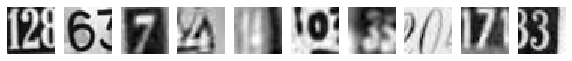

label for each of the above image: [2 6 7 4 4 0 3 0 7 3]
Model Prediction for each of the above image: [2 6 7 4 4 0 3 0 7 3]


In [116]:
sgd = optimizers.SGD(lr=.01, momentum=.2, nesterov=False)
model2.compile(loss=losses.sparse_categorical_crossentropy, optimizer=sgd, metrics=['sparse_categorical_accuracy'])

model2.fit(X_train, y_train, batch_size=200, epochs=30,validation_data=(X_test, y_test),verbose=0)

print(X_train.shape)
nnmodelPredictions = model2.predict_classes(X_train)

plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train_original[i], cmap="gray")
    plt.axis('off')
plt.show()
print('label for each of the above image: %s' % (y_train[0:10]))
print('Model Prediction for each of the above image: %s' % nnmodelPredictions[0:10])


From this we can infer that the prediciton of this model is better and more accurate. The time taken is significantly lower to build NN model as compared to the tradition classification with KNN. The accuracy of the model also significantly improves when using NN. We will store this model with the hyperparameters lr=0.1 and momentum=.2 for OCR of SVHN database. 


In [98]:
model2.save('./svhn_ocr_model.hd5')

Let's load the model and predict it with a sample image to see if the OCR is as expected.

In [132]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import cv2

model = load_model('svhn_ocr_model.hd5')


[2]


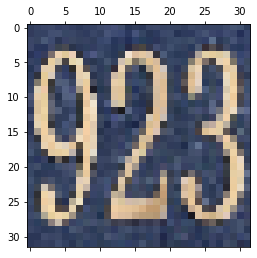

In [140]:
# Get test image ready
test_image = image.load_img('test.png', target_size=(32, 32))
plt.matshow(test_image)
test_image = image.img_to_array(test_image)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
test_image = test_image.reshape(-1, 1024) /255
result = model.predict_classes(test_image, batch_size=1)
print(result)

[7]


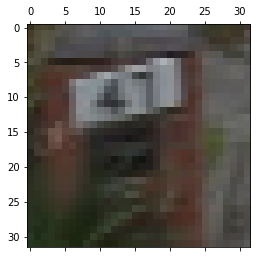

In [141]:
# Get test image ready
test_image = image.load_img('test2.png', target_size=(32, 32))
plt.matshow(test_image)
test_image = image.img_to_array(test_image)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
test_image = test_image.reshape(-1, 1024) /255
result = model.predict_classes(test_image, batch_size=1)
print(result)